In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!cp kaggle.json ~/.kaggle/

In [11]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d elderyouth/chinese-zodiac-signs --force

100% 2.06G/2.07G [00:24<00:00, 67.6MB/s]
100% 2.07G/2.07G [00:24<00:00, 90.9MB/s]


In [12]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [13]:
ls

chinese-zodiac-signs.zip  kaggle.json  sample_data/


In [14]:
!unzip \*.zip

Archive:  chinese-zodiac-signs.zip
  inflating: signs/test/dog/00000004.jpg  
  inflating: signs/test/dog/00000005.jpg  
  inflating: signs/test/dog/00000010.jpg  
  inflating: signs/test/dog/00000011.jpg  
  inflating: signs/test/dog/00000038.jpg  
  inflating: signs/test/dog/00000039.jpg  
  inflating: signs/test/dog/00000144.jpeg  
  inflating: signs/test/dog/00000164.jpg  
  inflating: signs/test/dog/00000165.jpg  
  inflating: signs/test/dog/00000167.jpg  
  inflating: signs/test/dog/00000170.jpg  
  inflating: signs/test/dog/00000173.jpg  
  inflating: signs/test/dog/00000206.jpg  
  inflating: signs/test/dog/00000207.jpg  
  inflating: signs/test/dog/00000212.jpg  
  inflating: signs/test/dog/00000213.jpg  
  inflating: signs/test/dog/00000359.jpg  
  inflating: signs/test/dog/00000365.jpg  
  inflating: signs/test/dog/00000366.jpg  
  inflating: signs/test/dog/00000371.jpg  
  inflating: signs/test/dog/00000372.jpg  
  inflating: signs/test/dog/00000373.jpg  
  inflating: signs

In [15]:
!pip install nonechucks
from torchvision import datasets, transforms
import torch
import numpy as np
import nonechucks as nc

data_dir = 'signs/'


transform = transforms.Compose([transforms.Resize(225),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_dir + 'train', transform=transform)
train_dataset = nc.SafeDataset(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)

valid_dataset = datasets.ImageFolder(data_dir + 'valid', transform=transform)
valid_dataset = nc.SafeDataset(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=True)

test_dataset = datasets.ImageFolder(data_dir + 'test', transform=transform)
test_dataset = nc.SafeDataset(test_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

classes=['dog','dragon','goat','horse','monkey','ox','pig','rabbit','rat','rooster','snake','tiger']


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

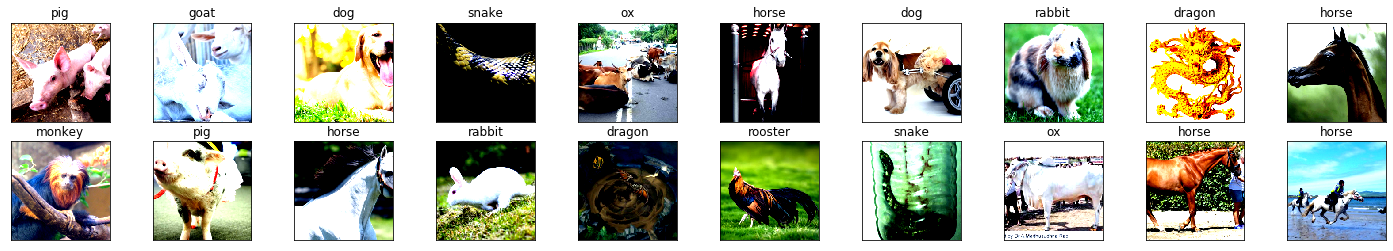

In [17]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [18]:
import torch
import torchvision.models as models

# define DENSENET model
DSNET = models.densenet161(pretrained=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DSNET = DSNET.cuda().to(device)
print('Use ' + device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 82.2MB/s]


Use cuda


In [0]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(DSNET.parameters(), lr=0.009)

In [21]:

n_epochs = 35

valid_loss_min = np.Inf 

for epoch in range(n_epochs):

    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model 
    DSNET.train()
    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = DSNET(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    # validate the model 
    DSNET.eval()
    for images, labels in valid_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        output = DSNET(images)
        loss = criterion(output, labels) 
        valid_loss += loss.item()*images.size(0)
  
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
         
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        valid_loss_min = valid_loss
        torch.save(DSNET.state_dict(), 'DSNET_zodiac.pt')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 0 	Training Loss: 8.548315 	Validation Loss: 3.556028
Validation loss decreased (inf --> 3.556028).  Saving model ...
Epoch: 1 	Training Loss: 1.620439 	Validation Loss: 2.329698
Validation loss decreased (3.556028 --> 2.329698).  Saving model ...
Epoch: 2 	Training Loss: 0.639398 	Validation Loss: 2.171593
Validation loss decreased (2.329698 --> 2.171593).  Saving model ...
Epoch: 3 	Training Loss: 0.297565 	Validation Loss: 2.216626
Epoch: 4 	Training Loss: 0.210878 	Validation Loss: 2.088354
Validation loss decreased (2.171593 --> 2.088354).  Saving model ...
Epoch: 5 	Training Loss: 0.155897 	Validation Loss: 2.062384
Validation loss decreased (2.088354 --> 2.062384).  Saving model ...
Epoch: 6 	Training Loss: 0.118715 	Validation Loss: 2.098781
Epoch: 7 	Training Loss: 0.083194 	Validation Loss: 2.143049
Epoch: 8 	Training Loss: 0.062177 	Validation Loss: 2.357648
Epoch: 9 	Training Loss: 0.071829 	Validation Loss: 2.426246
Epoch: 10 	Training Loss: 0.068527 	Validation Los

In [23]:
DSNET.load_state_dict(torch.load('DSNET_zodiac.pt'))

test_loss = 0.0
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))

DSNET.eval()
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    output = DSNET(images)
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(12):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(12):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.124572

Test Accuracy of   dog: 94% (33/35)
Test Accuracy of dragon: 94% (32/34)
Test Accuracy of  goat: 96% (29/30)
Test Accuracy of horse: 100% (32/32)
Test Accuracy of monkey: 94% (32/34)
Test Accuracy of    ox: 93% (31/33)
Test Accuracy of   pig: 96% (30/31)
Test Accuracy of rabbit: 100% (31/31)
Test Accuracy of   rat: 93% (29/31)
Test Accuracy of rooster: 94% (33/35)
Test Accuracy of snake: 100% (35/35)
Test Accuracy of tiger: 100% (35/35)

Test Accuracy (Overall): 96% (382/396)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

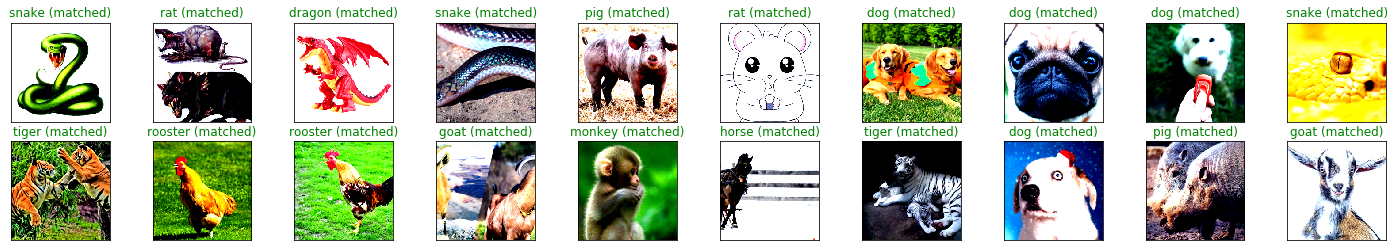

In [24]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = DSNET(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]],"matched" if classes[labels[idx]]==classes[preds[idx]] else "unmatched"),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))